# Lab1
Welcome to the Turtlebot4 Orientation Lab. Here you will learn to:
* Read data from the robots services
* Drive the robot around
* Accuracy of the odometry

Next, just execute the code cells below in sequence, read the comments, the output, and see what happens.

In [1]:
# The output will appear below.
print(2+2)

4


# Load Robot wrapper and initialize ROS
While the Turtlebot4 works using ROS2, you are using a wrapper around
ROS2 to make things more straight forward. 

You can inspect the wrapper by opening the file [/opt/robohub/humble/lib/python3.10/site-packages/turtlebot4_wrapper/\_\_init__.py](/opt/robohub/humble/lib/python3.10/site-packages/turtlebot4_wrapper/\_\_init__.py)

In [1]:
import turtlebot4_wrapper

turtlebot4_wrapper.use_hardware()
# turtlebot4_wrapper.use_simulation()

# load ROS library
import rclpy
if not rclpy.ok():
    rclpy.init()

# Instantiate Wrapper. The subscribes and publishes the relevant topics and connects the actions.
if not "robot" in globals():
    robot = turtlebot4_wrapper.Robot()

You are connected to uwbot-15
Robot is reachable


Could not determine the type for the passed topic


ros2 topic echo --once /ip failed. Proceed with caution.
ros2 topic subscription working. Everything is working as expected.


# Example: Read data from topics: Battery charge state
Check Battery State. Note: 10% get you 10 minutes of runtime.


In [2]:
# Make sure we have fresh data by waiting for a new message
robot.battery_state_future = rclpy.Future()
robot.spin_until_future_completed(robot.battery_state_future)

# Pretty print the contents of the message
print("Battery {0:2.3}%, charging with {1:2.2}A".format(
    robot.last_battery_state_msg.percentage*100,
    robot.last_battery_state_msg.current
))

Battery 1e+02%, charging with -0.52A


# Example: Drive the robot via teleoperation
First, undock the robot using a preprogrammed behavior. Then open the visualization to drive the robot using buttons. After you are done, dock the robot again.

In [4]:
robot.undock()

irobot_create_msgs.action.Undock_Result(is_docked=False)

In [ ]:
robot.open_visualization()

In [ ]:
print("You can additional move the robot with your phone:")
robot.open_visualization(open_url=False,mobile_layout=True,display_qrcode=True)

On the new webpage In the foxglove visualizer, you can drive the robot with panels in the bottom right hand corner. After you are done exploring, position the robot so that it is approximately 1-2m away from the dock and is pointing towards the dock.

In [13]:
robot.dock()

irobot_create_msgs.action.Dock_Result(is_docked=True)

# Example: Drive a square shape
In this example the robot automatically drives a square shape. While this is interesting to watch, it shows also some challenges. Before you execute this, mark the start position on the floor using tape as shown below (TODO: picture. Place your start position such that the robot has at least 0.5m space to the front and 0.5m to the left. Then execute the next cell. The code will also start a background logging process so you can analyze the data later.

In [ ]:
# send_cmd_vel (forward_velocity, rotation_velocity, duration)
robot.reset_odometry() # make the robot think it is at position (0,0,0) 
robot.configure_logging(["/odom","/tf","/tf_static","/scan"]) # set topics which should be recorded
robot.start_logging() # start the background logging process
for iterations in range(10): # drive the square
    robot.set_cmd_vel(0.4, 0.0, 2.) # 0.1   
    robot.set_cmd_vel(0.0, 0.5, 3.14)       #Turn 90 degress at 0.5 rad/s
    robot.set_cmd_vel(0.4, 0.0, 2.) # 0.1
    robot.set_cmd_vel(0.0, 0.5, 3.14)
    robot.set_cmd_vel(0.4, 0.0, 2.) # 0.1
    robot.set_cmd_vel(0.0, 0.5, 3.14)
    robot.set_cmd_vel(0.4, 0.0, 2.) # 0.1
    robot.set_cmd_vel(0.0, 0.5, 3.14)
logging_dir = robot.stop_logging()
log_data = robot.get_logging_data(logging_dir) # parse the logged data and import in python

Executing the next cell will open the log data in the visualizer.

In [4]:
robot.open_logging_data_in_visualizer(logging_dir)
robot.delete_logging_data(logging_dir)

NameError: name 'logging_dir' is not defined

Collected 4189 samples


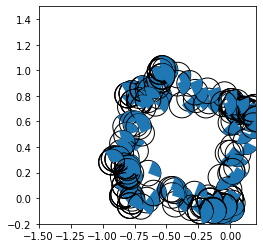

In [ ]:
# Plot data in the notebook
print("Collected {} samples".format(len(log_data['/odom'])))
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge
fig,ax = plt.subplots(1)
ax.set_aspect('equal')
# TODO: decide if x forward is really the way to go
plt.xlim([-1.5,0.2])
plt.ylim([-0.2,1.5])
for msg in log_data['/odom'][::20]:
    T3D = robot.convert_odom_to_transform(msg[1].pose.pose)
    T2D = robot.reduce_transform_to_2D(T3D)
    circ = Circle((-T2D[1,2],T2D[0,2]),0.1) # TODO: correct radius
    circ.set_fill(False)
    ax.add_patch(circ)
    angle = robot.rotation_from_transform(T2D)
    import math
    angle = angle/math.pi*180
    wedge = Wedge((-T2D[1,2],T2D[0,2]),0.1, angle+180+45, angle+360-45)
    ax.add_patch(wedge)

From the experiment, please try to explain two aspect:
* Discrepancies between the commanded robot motion and the executed one
* Discrepancies between the measured motion and the one you observed
Try to come up with an answer and write it in the next field

# Use this field

Odometry measures the displacement by taking data from motion sensors. It takes  information from the wheel encoders to measure the distance and direction the wheels have travelled: https://computersciencewiki.org/index.php/Odometry_sensor

Observations: After the second square, the position of the robot was not the same as the initial one. After 2 mins, the robot start moving in a diamond shape intead of the square shape (relative to the walls), and it's not following the same path every cycle. I think the problem is because it rotates 90 degress relative to itslef at every corner, and this can lead to an accumulated error that makes the robot to travel a different path. After 10 runs, the robot ended up outside the initial position.

![Initial and Final Positions](image.png)



Later, after you are done with this lab please save this notebook. Then commit the repository and push it. Detailled instructions will follow, but this is how you submit your work in this course.

# Example: Drive robot and aquire odometry
Tape measure, tape. Optional: Laser pointer.

* Tape two parallel lines `0.2m` apart on the floor. These are start and finish lines `0.2m`.
* Place the robot at the start line
* Read data from the Odometry topic
* Command the robot to drive `0.2m` straight
* Read data from the Odometry topic.
Did the robot travel `0.2m`? Where could the error come from?

Modify the experiment to investigate the behavior for rotation. Instead of the start and finish line attach a laser pointer to the base and aim it at a reference point. Command the robot to turn one full revolution.

Reading:
- Odometry sensor: TODO: find link https://robohub.eng.uwaterloo.ca/foxglove/?ds=remote-file&ds.url=https%3A%2F%2Frobohub.eng.uwaterloo.ca%2Fshare%2Fnotebook_bag_1695664686_0.mcap&layoutId=b648e2fc-b296-4190-9373-b059560482e6&layoutUrl=https%3A%2F%2Frobohub.eng.uwaterloo.ca%2Fuwbot%2Fturtlebot4_layout.json&time=2023-09-25T17%3A59%3A29.913750910Z
- Quaternions: https://en.wikipedia.org/wiki/Quaternion#Quaternions_and_the_space_geometry


In [ ]:
# Use preprogrammed behavior: Drive off the dock in a controlled way
robot.undock()

irobot_create_msgs.action.Undock_Result(is_docked=False)

In [5]:
robot.reset_odometry() # make the robot think it is at position (0,0,0)

In [29]:
# Display raw data: Odometry based position
robot.odom_future = rclpy.Future()
pose1 = robot.spin_until_future_completed(robot.odom_future).pose.pose
print(pose1.position)
print(pose1.orientation)

geometry_msgs.msg.Point(x=1.4605164722070185e-07, y=-1.6848491668497445e-07, z=-1.299187979419969e-09)
geometry_msgs.msg.Quaternion(x=0.008233926258981228, y=-0.005076969042420387, z=4.2641026084311306e-05, w=0.9999532103538513)


In [8]:
# Drive with desired velocity command:
velocity_x = 0.1 # in m/s
velocity_phi = 0. # for rotation test use 0.5 rad/s
duration = 2. # in s
robot.set_cmd_vel(velocity_x, velocity_phi, duration)

In [12]:
#One full revolution
velocity_x = 0.0 # in m/s
velocity_phi = 0.5 # for rotation test use 0.5 rad/s
duration = 12.56 # in s
robot.set_cmd_vel(velocity_x, velocity_phi, duration)

In [15]:
# Display raw data: Odometry based position
robot.odom_future = rclpy.Future()
pose2 = robot.spin_until_future_completed(robot.odom_future).pose.pose
print(pose2.position)
print(pose2.orientation)

geometry_msgs.msg.Point(x=-0.1052156463265419, y=-0.08602335304021835, z=-0.0017092538764700294)
geometry_msgs.msg.Quaternion(x=-0.012342307716608047, y=0.005424319766461849, z=-0.9997228384017944, w=0.019298983737826347)


In [ ]:
# translation
print("Desired distance: {}".format(velocity_x*duration))
import numpy
print("Measured distance: {}".format(
    numpy.sqrt( (pose1.position.x - pose2.position.x)**2 + (pose1.position.y - pose2.position.y)**2 ) ))

# rotation
import eigenpy # makes use of the Eigen C++ library ()
def make_quaternion(q):
    return eigenpy.Quaternion(q.w,q.x,q.y,q.z)
print("Desired rotation: {}".format(
    velocity_phi * duration))
print("Measured rotation: {}".format(
    make_quaternion(pose1.orientation).angularDistance(make_quaternion(pose2.orientation))))


The robot moved 0.24 m and the error could be because of the floor's friction. I think the floor texture could affect the robot's motion, and it could have slipped. Moreover, it can be seen a bit of rotation in the measured rotation that could affect the travelled distance.

The full rotation was affected a bit, but this can be because of the use of not precise calculations to estimate the duration. 